kvasir dataset split into neg/pos and trained using resnet50 witouth augmentation. With rejection resampling (see https://www.tensorflow.org/guide/data#resampling)

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import IPython.display as display
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

from PIL import Image

%matplotlib inline

In [2]:
MODEL = 'resnet50'
DS_INFO = 'binary'
NUM_EPOCHS = 2
BATCH_SIZE = 128
IMG_HEIGHT = 64  #224
IMG_WIDTH = 64

NUM_CHANNELS = 3
NUM_CLASSES = 2
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# epoch*batch_size*img_size
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

In [3]:
def print_class_info(names, pos, neg):
    # Extract and print info about the class split 
    
    list_class = [pos, neg]
    idx = 0
    for class_ in list_class:
        print ("{} class names:".format(names[idx]))
        for cl in class_:
            print ("{}- {}".format(" "*8, cl))
        idx += 1
    
    neg_count = 0
    pos_count = 0
    for class_name in original_class_names:
        # Number of samples in 'class_name' folder
        class_samples = len(list(data_dir.glob(class_name+'/*.jpg')))

        if (class_name == neg_class_name[0]):
            neg_count += class_samples
        else:
            pos_count += class_samples

    print ('\nNegative samples: {0:5} | {1:5.2f}%'.format(neg_count, neg_count/DATASET_SIZE*100))
    print ('Positive samples: {0:5} | {1:5.2f}%'.format(pos_count, pos_count/DATASET_SIZE*100))
    # Print number of images in dataset (excluded samples in outcast)
    print ('\nTotal number of images:', DATASET_SIZE)

In [4]:
# data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/kvasir-dataset-v2/')
outcast = 'polyps'

DATASET_SIZE = len(list(data_dir.glob('[!'+str(outcast)+']*/*.jpg')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
print ("Classes in data_dir: ", class_names)

# Remove outcasts
original_class_names = np.delete(class_names, np.where(outcast == class_names))
print ("\nRemoved outcast: ", outcast, "\n")

class_names = np.array(['Negative', 'Positive'])
neg_class_name = ['normal-pylorus']
pos_class_names = np.delete(original_class_names, np.where(neg_class_name == original_class_names))

print_class_info(class_names, pos_class_names, neg_class_name)

Classes in data_dir:  ['normal-cecum' 'polyps' 'normal-pylorus' 'esophagitis' 'normal-z-line'
 'ulcerative-colitis' 'dyed-resection-margins' 'dyed-lifted-polyps']

Removed outcast:  polyps 

Negative class names:
        - normal-cecum
        - esophagitis
        - normal-z-line
        - ulcerative-colitis
        - dyed-resection-margins
        - dyed-lifted-polyps
Positive class names:
        - normal-pylorus

Negative samples:  1000 | 14.29%
Positive samples:  6000 | 85.71%

Total number of images: 7000


In [5]:
# Create a dataset of the file paths | data_dir/*/* but subract class
list_ds = tf.data.Dataset.list_files(str(data_dir/'[!')+str(outcast+']*/*'))

Set up pipeline for loading images from given list of paths

In [6]:
def get_label_int(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bc = parts[-2] == pos_class_names
    nz_cnt = tf.math.count_nonzero(bc)
    if (nz_cnt > 0):
        return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=1), tf.int32),[-1])
    return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=0), tf.int32),[-1])

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

<Figure size 432x288 with 0 Axes>

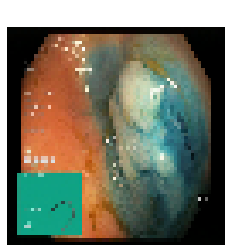

In [7]:
def show_image(img):
    for image, label in img:
        plt.figure();
        plt.figure(frameon=False, facecolor='white')
        plt.title(class_names[label.numpy()][0], fontdict={'color':'white','size':20})
        plt.imshow(image.numpy())
        plt.axis('off')

show_image(labeled_ds.take(1))

### Resampling the dataset to a 50/50 distribution

In [8]:
labeled_ds = labeled_ds.batch(BATCH_SIZE)

In [15]:
def count(counts, batch):
        features, labels = batch
        class_1 = labels[0] == 1
#         class_1 = tf.cast(class_1, tf.uint8)
        class_1 = tf.cast(class_1, tf.int32)

        class_0 = labels[0] == 0
#         class_0 = tf.cast(class_0, tf.uint8)
        class_0 = tf.cast(class_0, tf.int32)

        counts['class_0'] += tf.reduce_sum(class_0)
        counts['class_1'] += tf.reduce_sum(class_1)

        return counts

In [17]:
counts = labeled_ds.take(20).reduce(
        initial_state={'class_0': 0, 'class_1': 0},
        reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.1 0.9]


In [18]:
# data.experimental.rejection_resample takes a class_func argument. This class_func is applied to each dataset element, 
# and is used to determine which class an example belongs to for the purposes of balancing.

def class_func(features, label):
    return label[0]

In [19]:
# The resampler also needs a target distribution, and optionally an initial distribution estimate:

resampler = tf.data.experimental.rejection_resample(
        class_func, target_dist=[0.5, 0.5], initial_dist=fractions)

In [20]:
resample_ds = labeled_ds.unbatch().apply(resampler).batch(BATCH_SIZE)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [21]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [32]:
for images, labels in balanced_ds.take(3):
    labels = labels.numpy()
    total = len(labels)
    labels = np.resize(labels,(1,total))[-1]
    
    ones = np.count_nonzero(labels)
    zeros = total - ones
    
    print (labels)
    print ("ones: ", ones)
    print ("zeros: ", zeros)
    print ("total: ", total)

[1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1
 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1]
ones:  111
zeros:  17
total:  128
[1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
ones:  108
zeros:  20
total:  128
[0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1]
ones:  105
zeros:  23
total:  128


In [ ]:
# Verify that it has been resampled

counts = resample_ds.take(10).reduce(
        initial_state={'class_0': 0, 'class_1': 0},
        reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

### Splitting into training, test and validation data

In [ ]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

shuffled_ds = labeled_ds#.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [ ]:
# Print info about the dataset split
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(shuffled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/train_{}.tfcache".format(IMG_WIDTH))
test_ds = prepare_for_training(test_ds, cache="./cache/test_{}.tfcache".format(IMG_WIDTH))
val_ds = prepare_for_training(val_ds, cache="./cache/val_{}.tfcache".format(IMG_WIDTH))

## Training
https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/

In [ ]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import layers

In [ ]:
res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE)

In [ ]:
res_net.trainable = False

global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(1, activation='sigmoid')

tl_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        output_layer])

In [ ]:
tl_model.summary()

In [ ]:
tl_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/transfer_learning_model', update_freq='batch')]

In [ ]:
history = tl_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = callbacks)

`Keras`
Save/load the model

In [ ]:
tl_model.save('models/{}.h5'.format(model_name))
# tl_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Validate the results

`Tensorboard`

In [ ]:
# Clear any logs from previous runs (move to .old instead?)
# !rm -rf ./logs/

In [ ]:
# Start tensorboard
%tensorboard --logdir logs

In [ ]:
# !kill 20058

In [ ]:
result = tl_model.evaluate(
            val_ds,
            steps = val_size//BATCH_SIZE)

## Predict new samples

In [ ]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

In [ ]:
# Get a random image and label
idx = np.random.randint(0, BATCH_SIZE)
idx = 4
image = images[idx]
label = labels[idx]

# Predict one image
result = tl_model.predict(np.expand_dims(image, axis=0))[0][0]

print ("True label:", class_names[label[0]])
print ('Probabibity of Positive: {:.5f}%'.format((result)*100))

plt.figure()
plt.imshow(image)
plt.axis('off');

In [ ]:
# Predict one batch
results = tl_model.predict(images)

print ('{:3}  {:7}  {:3}%'.format('idx', 'true_label', 'pred_prob'))
print ('---  ---------   ----------')
idx = 0
for result in results:
    true_label = class_names[labels[idx]][0]
    pred_prob = result[0]
    print ('{:3}  {:10}  {:05f}%'.format(idx, true_label, pred_prob))
    idx += 1